In [15]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import spacy
import re
import string
import random
from PIL import Image
import requests
from io import BytesIO
#import matplotlib.pyplot as plt
#import seaborn as sns
#%matplotlib inline
import ast
from textblob import TextBlob
import nltk



In [ ]:
#pip install textblob

## Carga del dataset

In [17]:
#Importar el dataset
df = pd.read_csv("books.csv")
df = df.dropna(subset=['description']) #Se elimina los libros que no tengan descripcion
df['genres'] = df['genres'].apply(ast.literal_eval) #Los generos vienen en string, se convierte en formato list


In [18]:
df.head()

,title,series,author,rating,description,language,isbn,genres,characters,bookFormat,...,publishDate,firstPublishDate,awards,numRatings,ratingsByStars,likedPercent,setting,bbeScore,bbeVotes,price
0,The Hunger Games,The Hunger Games #1,Suzanne Collins,4.33,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,English,9.78044E+12,"[Young Adult, Fiction, Dystopia, Fantasy, Scie...","['Katniss Everdeen', 'Peeta Mellark', 'Cato (H...",Hardcover,...,09/14/08,NaN,['Locus Award Nominee for Best Young Adult Boo...,6376780,"['3444695', '1921313', '745221', '171994', '93...",96.0,"['District 12, Panem', 'Capitol, Panem', 'Pane...",2993816,30516,5.09
1,Harry Potter and the Order of the Phoenix,Harry Potter #5,"J.K. Rowling, Mary GrandPré (Illustrator)",4.50,There is a door at the end of a silent corrido...,English,9.78044E+12,"[Fantasy, Young Adult, Fiction, Magic, Childre...","['Sirius Black', 'Draco Malfoy', 'Ron Weasley'...",Paperback,...,09/28/04,06/21/03,['Bram Stoker Award for Works for Young Reader...,2507623,"['1593642', '637516', '222366', '39573', '14526']",98.0,['Hogwarts School of Witchcraft and Wizardry (...,2632233,26923,7.38
2,To Kill a Mockingbird,To Kill a Mockingbird,Harper Lee,4.28,The unforgettable novel of a childhood in a sl...,English,1E+13,"[Classics, Fiction, Historical Fiction, School...","['Scout Finch', 'Atticus Finch', 'Jem Finch', ...",Paperback,...,05/23/06,07-11-1960,"['Pulitzer Prize for Fiction (1961)', 'Audie A...",4501075,"['2363896', '1333153', '573280', '149952', '80...",95.0,"['Maycomb, Alabama (United States)']",2269402,23328,NaN
3,Pride and Prejudice,NaN,"Jane Austen, Anna Quindlen (Introduction)",4.26,Alternate cover edition of ISBN 9780679783268S...,English,1E+13,"[Classics, Fiction, Romance, Historical Fictio...","['Mr. Bennet', 'Mrs. Bennet', 'Jane Bennet', '...",Paperback,...,10-10-2000,01/28/13,[],2998241,"['1617567', '816659', '373311', '113934', '767...",94.0,"['United Kingdom', 'Derbyshire, England (Unite...",1983116,20452,NaN
4,Twilight,The Twilight Saga #1,Stephenie Meyer,3.60,About three things I was absolutely positive.\...,English,9.78032E+12,"[Young Adult, Fantasy, Romance, Vampires, Fict...","['Edward Cullen', 'Jacob Black', 'Laurent', 'R...",Paperback,...,09-06-2006,10-05-2005,"['Georgia Peach Book Award (2007)', 'Buxtehude...",4964519,"['1751460', '1113682', '1008686', '542017', '5...",78.0,"['Forks, Washington (United States)', 'Phoenix...",1459448,14874,2.1


In [21]:
df.shape

(51140, 23)

In [6]:
df.columns

Index(['title', 'series', 'author', 'rating', 'description', 'language',
       'isbn', 'genres', 'characters', 'bookFormat', 'edition', 'pages',
       'publisher', 'publishDate', 'firstPublishDate', 'awards', 'numRatings',
       'ratingsByStars', 'likedPercent', 'setting', 'bbeScore', 'bbeVotes',
       'price'],
      dtype='object')

# Analisis de los datos

## Analisis de generos

In [8]:
#Distribucion de generos, debido a que vienen varios para cada libro, separamos para poder analizar 
df_generos = df[['title','genres']].copy()
#df_generos['genres'] = df_generos['genres'].apply(ast.literal_eval)
df_generos_exploded = df_generos.explode('genres')
df_generos_exploded

,title,genres
0,The Hunger Games,Young Adult
0,The Hunger Games,Fiction
0,The Hunger Games,Dystopia
0,The Hunger Games,Fantasy
0,The Hunger Games,Science Fiction
...,...,...
52477,Daughter of Helaman,Lds
52477,Daughter of Helaman,Historical
52477,Daughter of Helaman,Romance
52477,Daughter of Helaman,Adventure


In [9]:
# Cantidad de libros por genero
genre_counts = df_generos_exploded['genres'].value_counts()
print(genre_counts)

genres
Fiction         31327
Romance         15406
Fantasy         14938
Young Adult     11791
Contemporary    10479
                ...  
Malawi              1
Babylon 5           1
Polyamorous         1
Usability           1
Guinea              1
Name: count, Length: 982, dtype: int64


In [10]:
# Se filtra para observar en la grafica solo los generos con mas de 3000 libros
filtered_genres_counts = genre_counts[genre_counts >= 3000]
print(filtered_genres_counts)

genres
Fiction                    31327
Romance                    15406
Fantasy                    14938
Young Adult                11791
Contemporary               10479
Adult                       8231
Nonfiction                  8121
Novels                      7702
Mystery                     7669
Historical Fiction          7608
Audiobook                   7278
Classics                    6750
Adventure                   6411
Historical                  6345
Paranormal                  6012
Literature                  5716
Science Fiction             5341
Childrens                   5145
Thriller                    4566
Magic                       4234
Humor                       4181
Crime                       3660
History                     3627
Contemporary Romance        3621
Suspense                    3464
Urban Fantasy               3451
Middle Grade                3379
Chick Lit                   3352
Science Fiction Fantasy     3286
Supernatural                3189
Bio

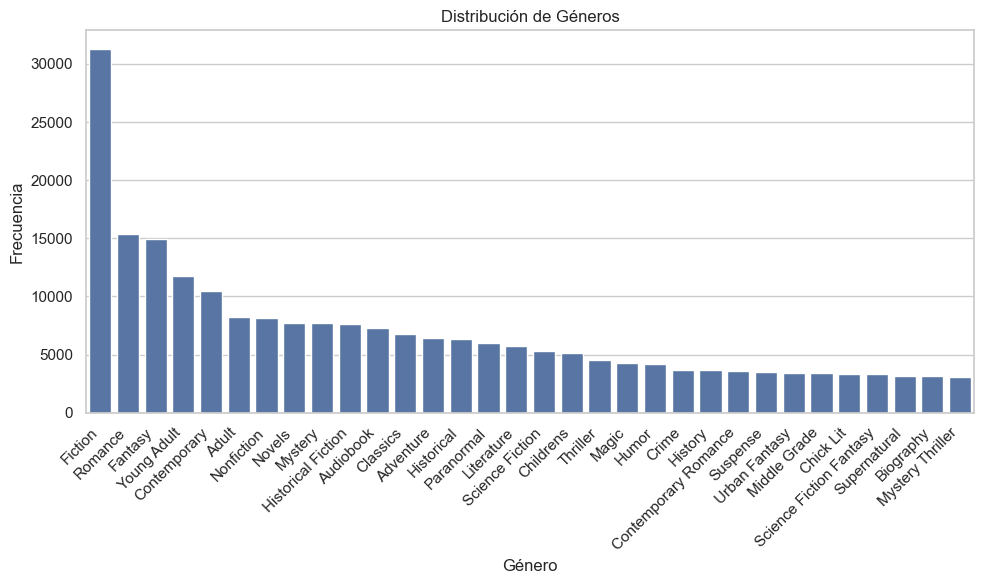

In [11]:
# Configurar el estilo del gráfico
sns.set(style="whitegrid")

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=filtered_genres_counts.index, y=filtered_genres_counts.values)

# Añadir etiquetas y título
plt.xlabel('Género')
plt.ylabel('Frecuencia')
plt.title('Distribución de Géneros')
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas del eje X para mejor legibilidad

# Mostrar el gráfico
plt.tight_layout()
plt.show()

## Analisis de descripcion

In [12]:
# Vamos a ver una descripcion random de un libro
print(df['title'] [4000])
print(df['description'][4000])

Coeur pourri de laine (DF)
Livre écrit par Lucio Rosenkreutz le 14 juillet 2014 dans Strasbourg, France. C'est une narration linguistique extensive, le résultat d'un homicide qui a eu lieu à Madrid-Espagne, la continuation du chapitre nº 10 du livre: « Grey Angel 2014 ».


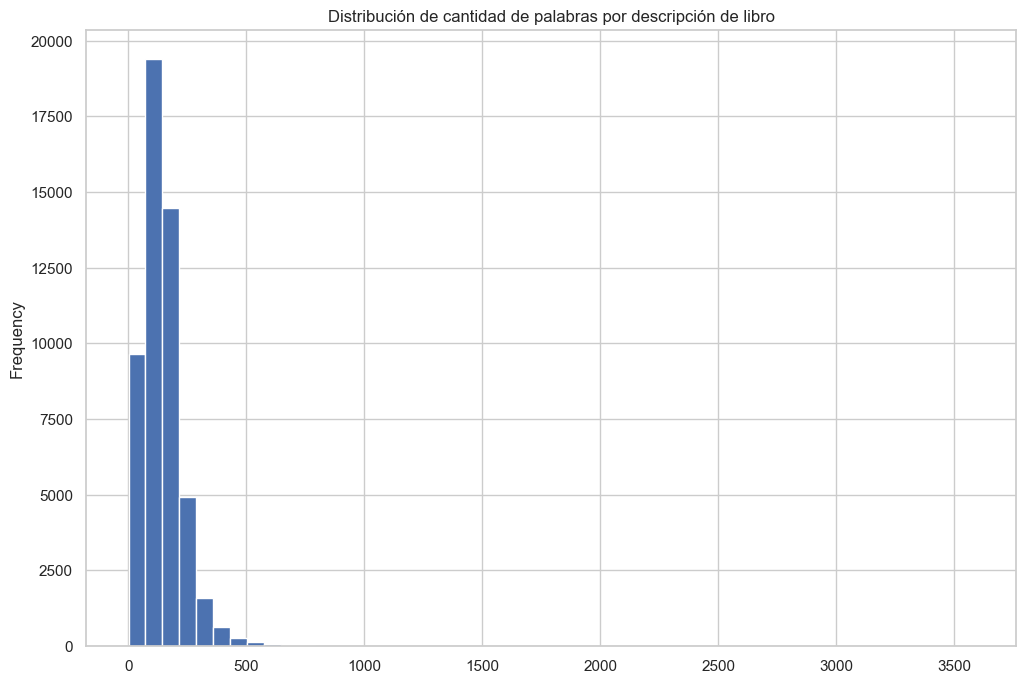

In [114]:
# Calculo de la cantidad de palabras por cada descripcion
df['word_count'] = df['description'].apply(lambda x: len(str(x).split()))# Se agrega una celda para tener la cantidad de palbras en la descripcion en cada libro
df['word_count'].plot(
    kind='hist',
    bins = 50,
    figsize = (12,8),title='Distribución de cantidad de palabras por descripción de libro')
plt.show()

<Axes: title={'center': 'Top 20 etiquetas Part-of-speech en descripción'}, xlabel='pos'>

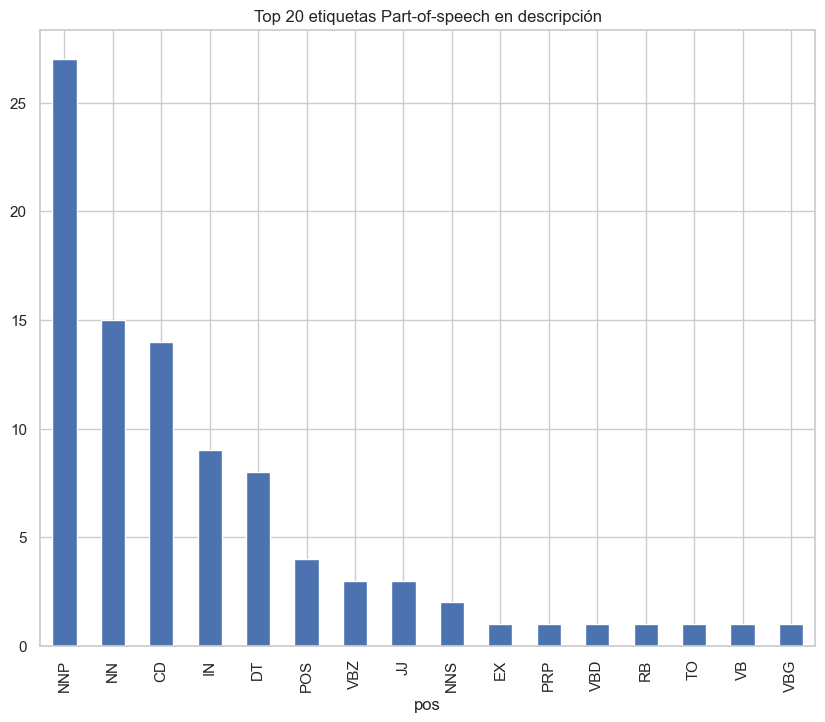

In [116]:
# Analisis de frecuencia de palabras POS en descripción
from textblob import TextBlob
blob = TextBlob(str(df['description'])) 
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20] #Muestra los 20 tipos de palabras con más frecuencia
pos_df.plot(kind = 'bar', figsize=(10, 8), title = "Top 20 etiquetas Part-of-speech en descripción")

<Axes: title={'center': 'Bigram disribution para las 20 palabras más frecuentes en la descripción'}, xlabel='bigram'>

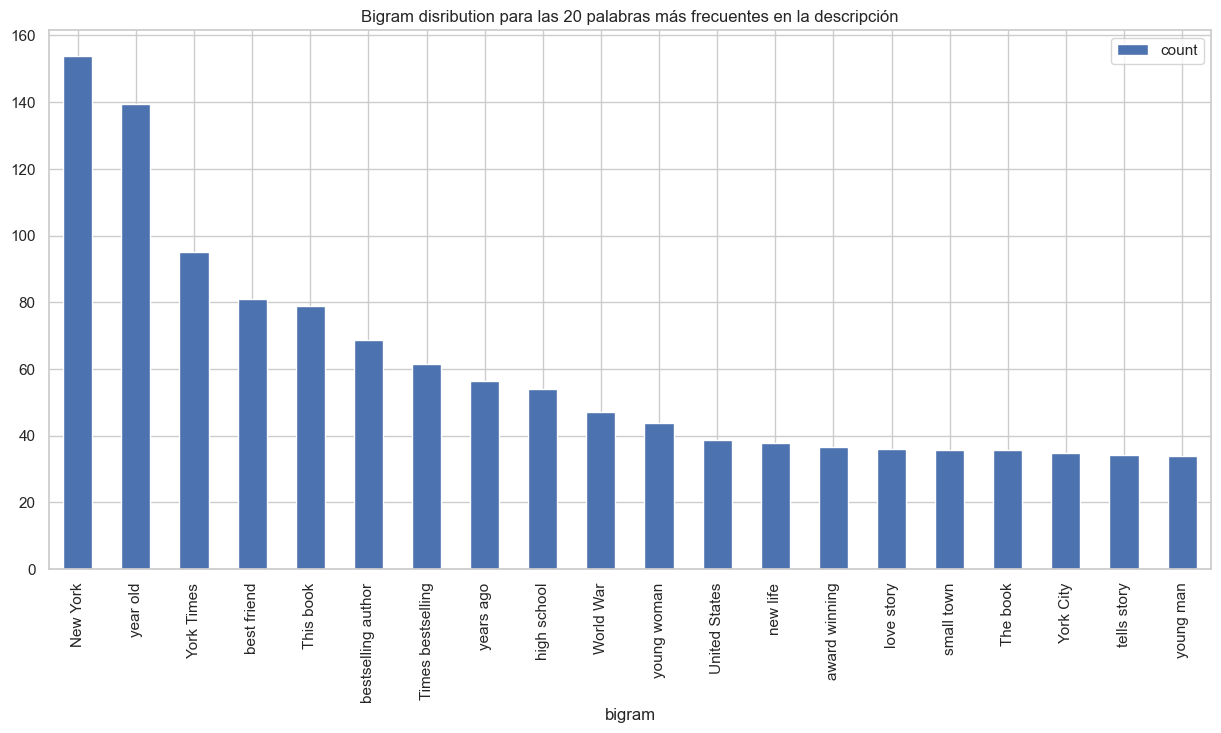

In [142]:
#Vemos la combinación de dos palabras más frecuentes (las 20 más frecuentes)
#Conversión del texto a vectores usando TF-IDF usando Bigram 
tf = TfidfVectorizer(ngram_range=(2, 2), stop_words='english', lowercase = False)
tfidf_matrix = tf.fit_transform(df['description']) 
total_words = tfidf_matrix.sum(axis=0) 
#Finding the word frequency
freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
freq =sorted(freq, key = lambda x: x[1], reverse=True)
#converting into dataframe 
bigram = pd.DataFrame(freq)
bigram.rename(columns = {0:'bigram', 1: 'count'}, inplace = True) 
#Taking first 20 records
bigram = bigram.head(20)

#Plotting the bigram distribution
bigram.plot(x ='bigram', y='count', kind = 'bar', title = "Bigram disribution para las 20 palabras más frecuentes en la descripción", figsize = (15,7), )

<Axes: title={'center': 'Trigram disribution para las 20 palabras más frecuentes en la descripción'}, xlabel='trigram'>

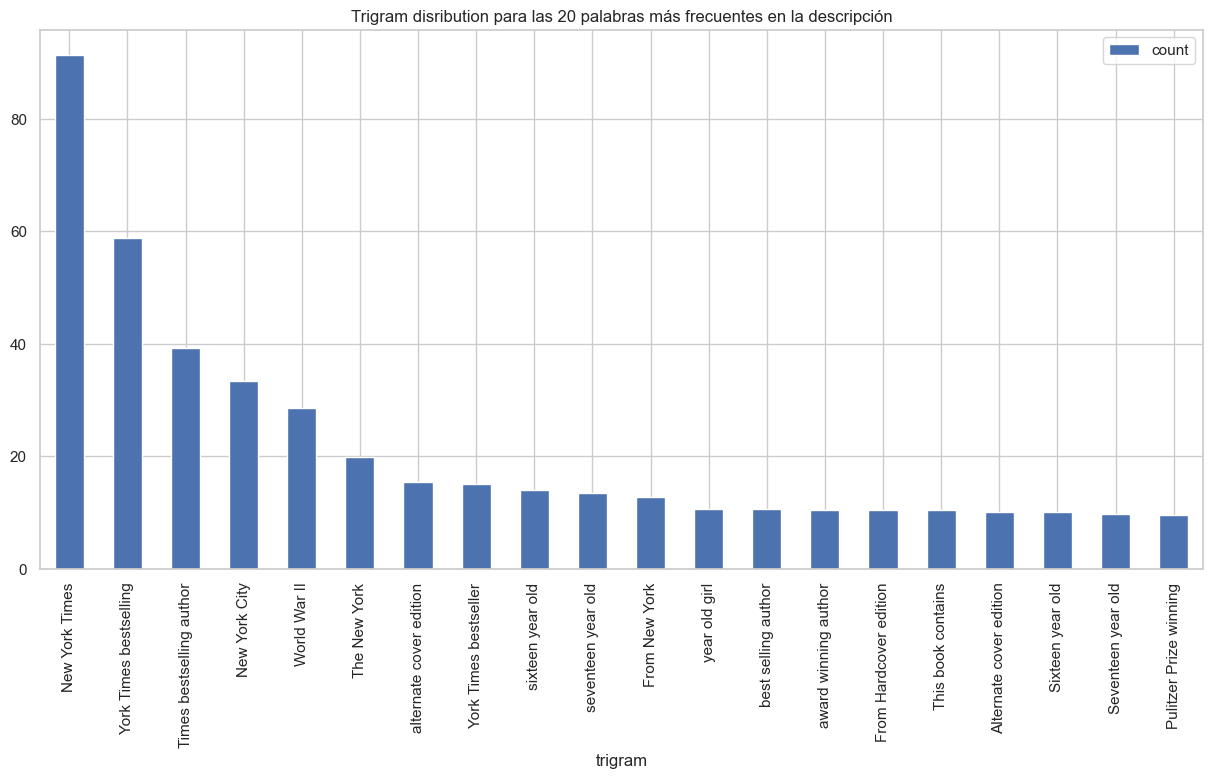

In [143]:
#Vemos la combinación de 3 palabras más frecuentes (las 20 más frecuentes)
#Conversión del texto a vectores usando TF-IDF usando Bigram 
tf = TfidfVectorizer(ngram_range=(3, 3), stop_words='english', lowercase = False)
tfidf_matrix = tf.fit_transform(df['description'])
total_words = tfidf_matrix.sum(axis=0) 
#Finding the word frequency
freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
freq =sorted(freq, key = lambda x: x[1], reverse=True)#converting into dataframe 
trigram = pd.DataFrame(freq)
trigram.rename(columns = {0:'trigram', 1: 'count'}, inplace = True) 
#Taking first 20 records
trigram = trigram.head(20)

#Plotting the trigramn distribution
trigram.plot(x ='trigram', y='count', kind = 'bar', title = "Trigram disribution para las 20 palabras más frecuentes en la descripción", figsize = (15,7), )

# Entrenamiento del modelo 

## Funciones para limpiar los datos

In [23]:
nlp = spacy.load("en_core_web_sm")

# Funcion para eliminar los NonAscii characters
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

# Funcion para convertir a minusculas
def make_lower_case(text):
    return text.lower()

# Funcion para eliminar las stop words
def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

# Función para eliminar la puntuación
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

# Función para eliminar html tags
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

# Función para realizar stemming
def apply_stemming(text):
    stemmer = PorterStemmer()
    text = text.split()
    text = [stemmer.stem(word) for word in text]
    text = " ".join(text)
    return text

# Función para lemmatization
def apply_lemmatization(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    text = " ".join(lemmas)
    return text

# Se limpia la columna de descripcion y see guarda en una nueva columna llamada cleaned_desc
df['cleaned_desc'] = df['description'].apply(_removeNonAscii)
df['cleaned_desc'] = df.cleaned_desc.apply(func = make_lower_case)
df['cleaned_desc'] = df.cleaned_desc.apply(func = remove_stop_words)
df['cleaned_desc'] = df.cleaned_desc.apply(func=remove_punctuation)
df['cleaned_desc'] = df.cleaned_desc.apply(func=remove_html)
#df['cleaned_desc'] = df.cleaned_desc.apply(func=apply_stemming)
df['cleaned_desc'] = df.cleaned_desc.apply(func=apply_lemmatization)

In [ ]:
df['cleaned_desc'] = df.cleaned_desc.apply(func=apply_lemmatization)

## Funciones para recomendar

### Función recomedación por titulo

### Función

In [26]:
#Función de recomendación por titulo
def recommend_title(title,genre):
    # Function for recommending books based on Book title. It takes book title and genre as an input.def recommend(title, genre):
    
    # Matching the genre with the dataset and reset the index
    data = df[df['genres'].apply(lambda x: genre in x)]
    data.reset_index(level = 0, inplace = True) 
  
    # Convert the index into series
    indices = pd.Series(data.index, index = data['title'])
    
    #Converting the book title into vectors and used bigram
    tf = TfidfVectorizer(analyzer='word', ngram_range=(2, 2), min_df = 1, stop_words='english')
    tfidf_matrix = tf.fit_transform(data['cleaned_desc'])
    
    # Calculating the similarity measures based on Cosine Similarity
    sg = cosine_similarity(tfidf_matrix, tfidf_matrix)
    
    # Get the index corresponding to original_title
       
    idx = indices[title]# Get the pairwsie similarity scores 
    sig = list(enumerate(sg[idx]))# Sort the books
    sig = sorted(sig, key=lambda x: x[1], reverse=True)# Scores of the 5 most similar books 
    sig = sig[1:6]# Book indicies
    movie_indices = [i[0] for i in sig]
   
    # Top 5 book recommendation
    rec = data[['title']].iloc[movie_indices]
    
    # It reads the top 5 recommended book urls and print the images
    for i in rec['title']:
        print(i)

### Resultado

In [25]:
recommend_title("Pride and Prejudice", "Fiction")

Pride and Prejudice and Zombies
Darcy's Story
Mr. Darcy Presents His Bride: A Sequel to Jane Austen's Pride and Prejudice
The Complete Novels of Jane Austen, Vol 1: Sense & Sensibility/Pride & Prejudice/Mansfield Park
Γαλήνη


# Textos a predecir

In [80]:
description_harry_potter = 'There is a door at the end of a silent corridor. And it’s haunting Harry Pottter’s dreams. Why else would he be waking in the middle of the night, screaming in terror?Harry has a lot on his mind for this, his fifth year at Hogwarts: a Defense Against the Dark Arts teacher with a personality like poisoned honey; a big surprise on the Gryffindor Quidditch team; and the looming terror of the Ordinary Wizarding Level exams. But all these things pale next to the growing threat of He-Who-Must-Not-Be-Named - a threat that neither the magical government nor the authorities at Hogwarts can stop.As the grasp of darkness tightens, Harry must discover the true depth and strength of his friends, the importance of boundless loyalty, and the shocking price of unbearable sacrifice.His fate depends on them all'
description_harry_potter_usuario_enter = 'Magic and they study in Hogwarts and its a boy with a scar and its his firts year in the school and he makes friends, and they study magic'
description_orgullo_y_prejuicio_usuario_enter = 'A man name Darcy and a woman name Elizabeth and they live in england, and its an enemys to lovers history and theres dances and dresses and society and its written by Jane Austen'
description_alas_de_sangre = "Twenty-year-old Violet Sorrengail was supposed to enter the Scribe Quadrant, living a quiet life among books and history. Now, the commanding general—also known as her tough-as-talons mother—has ordered Violet to join the hundreds of candidates striving to become the elite of Navarre: dragon riders.But when you’re smaller than everyone else and your body is brittle, death is only a heartbeat away…because dragons don’t bond to “fragile” humans. They incinerate them.With fewer dragons willing to bond than cadets, most would kill Violet to better their own chances of success. The rest would kill her just for being her mother’s daughter—like Xaden Riorson, the most powerful and ruthless wingleader in the Riders Quadrant.She’ll need every edge her wits can give her just to see the next sunrise.Yet, with every day that passes, the war outside grows more deadly, the kingdom’s protective wards are failing, and the death toll continues to rise. Even worse, Violet begins to suspect leadership is hiding a terrible secret.Friends, enemies, lovers. Everyone at Basgiath War College has an agenda—because once you enter, there are only two ways out: graduate or die"

descripciones_a_predecir = {'description_harry_potter' : [description_harry_potter, 'Fiction'] , 'description_harry_potter_usuario_enter': [description_harry_potter_usuario_enter , 'Fiction'], 'description_orgullo_y_prejuicio_usuario_enter' : [description_orgullo_y_prejuicio_usuario_enter, 'Romance'], 'description_alas_de_sangre' : [description_alas_de_sangre, 'Fantasy']}

description_harry_potter
There is a door at the end of a silent corridor. And it’s haunting Harry Pottter’s dreams. Why else would he be waking in the middle of the night, screaming in terror?Harry has a lot on his mind for this, his fifth year at Hogwarts: a Defense Against the Dark Arts teacher with a personality like poisoned honey; a big surprise on the Gryffindor Quidditch team; and the looming terror of the Ordinary Wizarding Level exams. But all these things pale next to the growing threat of He-Who-Must-Not-Be-Named - a threat that neither the magical government nor the authorities at Hogwarts can stop.As the grasp of darkness tightens, Harry must discover the true depth and strength of his friends, the importance of boundless loyalty, and the shocking price of unbearable sacrifice.His fate depends on them all
Fiction
description_harry_potter_usuario_enter
Magic and they study in Hogwarts and its a boy with a scar and its his firts year in the school and he makes friends, and t

## Función recomendación por descripción

### Recomendación sin lematización sin stop words sin stemming

#### Función

In [108]:
# Recomendar por descripción sin lematización sin stop words sin stemming

# Se limpia la columna de descripcion y see guarda en una nueva columna llamada cleaned_desc
df['cleaned_desc'] = df['description'].apply(_removeNonAscii)
df['cleaned_desc'] = df.cleaned_desc.apply(func = make_lower_case)

def recommend_description(description,genre,top_n=5):
     # Matching the genre with the dataset and reset the index
    data = df[df['genres'].apply(lambda x: genre in x)]
    data.reset_index(level=0, inplace=True)
    
    # Convert the index into series
    indices = pd.Series(data.index, index=data['title'])
    
    # Convert the book descriptions into vectors using TfidfVectorizer
    tf = TfidfVectorizer(analyzer='word', ngram_range=(2, 2), min_df=1, stop_words='english')
    tfidf_matrix = tf.fit_transform(data['cleaned_desc'])
    description_cleaned = _removeNonAscii(description)
    description_cleaned  = make_lower_case(description_cleaned)

    # Transform the input description into the same vector space
    desc_vector = tf.transform([description_cleaned])
    
    # Calculate the similarity measures based on Cosine Similarity
    sg = cosine_similarity(desc_vector, tfidf_matrix)
    # Obtener los índices de los top_n libros más similares
    top_indices = sg.argsort()[0][-top_n:][::-1]
    
    # Obtener los títulos de los libros más similares
    recommended_books = data['title'].iloc[top_indices].tolist()
    
    return recommended_books

#### Resultados

In [114]:
for nombre,descripcion in zip(descripciones_a_predecir.keys(),descripciones_a_predecir.values()):
    #print(recommend_description(descripcion[0], descripcion[1]))
    prediccion = recommend_description(descripcion[0], descripcion[1])
    print(f'Entrada: {nombre}')
    print(f'Genero: {descripcion[1]}')
    print('Predicción: ')
    for book in prediccion:
        print(book)
    print('')


Entrada: description_harry_potter
Genero: Fiction
Predicción: 
Harry Potter and the Order of the Phoenix
Harry Potter and the Prisoner of Azkaban
India Dark
xxxHolic, Vol. 11
Kissing Annabel: Love, Ghosts, and Facial Hair; A Place Like This

Entrada: description_harry_potter_usuario_enter
Genero: Fiction
Predicción: 
The Study Series Bundle
The Naughtiest Girl in the School
Harry Potter and the Methods of Rationality
The Soulforge
Embers & Echoes

Entrada: description_orgullo_y_prejuicio_usuario_enter
Genero: Romance
Predicción: 
A Weekend with Mr. Darcy
The Professor
Catharine and Other Writings
The Complete Novels of Jane Austen, Vol 1: Sense & Sensibility/Pride & Prejudice/Mansfield Park
Confessions of a Jane Austen Addict

Entrada: description_alas_de_sangre
Genero: Fantasy
Predicción: 
The Algebraist
Mirage
FLCL, Volume 1
The Vampire's Warden
The Voice



### Recomendación con stopwords sin lematización sin stemming

#### Función

In [120]:
# Se limpia la columna de descripcion y see guarda en una nueva columna llamada cleaned_desc
df['cleaned_desc'] = df['description'].apply(_removeNonAscii)
df['cleaned_desc'] = df.cleaned_desc.apply(func = make_lower_case)
df['cleaned_desc'] = df.cleaned_desc.apply(func = remove_stop_words)
df['cleaned_desc'] = df.cleaned_desc.apply(func=remove_punctuation)
df['cleaned_desc'] = df.cleaned_desc.apply(func=remove_html)

def recommend_description(description,genre,top_n=5):
     # Matching the genre with the dataset and reset the index
    data = df[df['genres'].apply(lambda x: genre in x)]
    data.reset_index(level=0, inplace=True)
    
    # Convert the index into series
    indices = pd.Series(data.index, index=data['title'])
    
    # Convert the book descriptions into vectors using TfidfVectorizer
    tf = TfidfVectorizer(analyzer='word', ngram_range=(2, 2), min_df=1, stop_words='english')
    tfidf_matrix = tf.fit_transform(data['cleaned_desc'])
    description_cleaned = _removeNonAscii(description)
    description_cleaned  = make_lower_case(description_cleaned )
    description_cleaned  = remove_stop_words(description_cleaned )
    description_cleaned  = remove_punctuation(description_cleaned )

    # Transform the input description into the same vector space
    desc_vector = tf.transform([description_cleaned])
    
    # Calculate the similarity measures based on Cosine Similarity
    sg = cosine_similarity(desc_vector, tfidf_matrix)
    # Obtener los índices de los top_n libros más similares
    top_indices = sg.argsort()[0][-top_n:][::-1]
    
    # Obtener los títulos de los libros más similares
    recommended_books = data['title'].iloc[top_indices].tolist()
    
    return recommended_books

#### Resultados

In [121]:
for nombre,descripcion in zip(descripciones_a_predecir.keys(),descripciones_a_predecir.values()):
    #print(recommend_description(descripcion[0], descripcion[1]))
    prediccion = recommend_description(descripcion[0], descripcion[1])
    print(f'Entrada: {nombre}')
    print(f'Genero: {descripcion[1]}')
    print('Predicción: ')
    for book in prediccion:
        print(book)
    print('')

Entrada: description_harry_potter
Genero: Fiction
Predicción: 
Harry Potter and the Order of the Phoenix
Harry Potter and the Prisoner of Azkaban
India Dark
xxxHolic, Vol. 11
Starring Winston Egbert

Entrada: description_harry_potter_usuario_enter
Genero: Fiction
Predicción: 
The Study Series Bundle
The Naughtiest Girl in the School
Harry Potter and the Methods of Rationality
The Soulforge
Embers & Echoes

Entrada: description_orgullo_y_prejuicio_usuario_enter
Genero: Romance
Predicción: 
A Weekend with Mr. Darcy
The Professor
Catharine and Other Writings
The Complete Novels of Jane Austen, Vol 1: Sense & Sensibility/Pride & Prejudice/Mansfield Park
Confessions of a Jane Austen Addict

Entrada: description_alas_de_sangre
Genero: Fantasy
Predicción: 
The Algebraist
Mirage
FLCL, Volume 1
The Vampire's Warden
The Voice



### Recomendación con stopwords con stemming


#### Función

In [128]:
df['cleaned_desc'] = df['description'].apply(_removeNonAscii)
df['cleaned_desc'] = df.cleaned_desc.apply(func = make_lower_case)
df['cleaned_desc'] = df.cleaned_desc.apply(func = remove_stop_words)
df['cleaned_desc'] = df.cleaned_desc.apply(func=remove_punctuation)
df['cleaned_desc'] = df.cleaned_desc.apply(func=remove_html)
df['cleaned_desc'] = df.cleaned_desc.apply(func=apply_stemming)### Recomendación con stopwords con stemming

def recommend_description(description,genre,top_n=5):
     # Matching the genre with the dataset and reset the index
    data = df[df['genres'].apply(lambda x: genre in x)]
    data.reset_index(level=0, inplace=True)
    
    # Convert the index into series
    indices = pd.Series(data.index, index=data['title'])
    
    # Convert the book descriptions into vectors using TfidfVectorizer
    tf = TfidfVectorizer(analyzer='word', ngram_range=(2, 2), min_df=1, stop_words='english')
    tfidf_matrix = tf.fit_transform(data['cleaned_desc'])
    description_cleaned = _removeNonAscii(description)
    description_cleaned  = make_lower_case(description_cleaned)
    description_cleaned  = remove_stop_words(description_cleaned)
    description_cleaned  = remove_punctuation(description_cleaned)
    description_cleaned  = apply_stemming(description_cleaned)
    #description_cleaned  = apply_lemmatization(description_cleaned)

    # Transform the input description into the same vector space
    desc_vector = tf.transform([description_cleaned])
    
    # Calculate the similarity measures based on Cosine Similarity
    sg = cosine_similarity(desc_vector, tfidf_matrix)
    # Obtener los índices de los top_n libros más similares
    top_indices = sg.argsort()[0][-top_n:][::-1]
    
    # Obtener los títulos de los libros más similares
    recommended_books = data['title'].iloc[top_indices].tolist()
    
    return recommended_books

#### Resultados

In [131]:
for nombre,descripcion in zip(descripciones_a_predecir.keys(),descripciones_a_predecir.values()):
    #print(recommend_description(descripcion[0], descripcion[1]))
    prediccion = recommend_description(descripcion[0], descripcion[1])
    print(f'Entrada: {nombre}')
    print(f'Genero: {descripcion[1]}')
    print('Predicción: ')
    for book in prediccion:
        print(book)
    print('')

Entrada: description_harry_potter
Genero: Fiction
Predicción: 
Harry Potter and the Order of the Phoenix
Harry Potter and the Prisoner of Azkaban
The Bad Boy Stole My Bra
The Torture Garden
Darkest Hour

Entrada: description_harry_potter_usuario_enter
Genero: Fiction
Predicción: 
The Study Series Bundle
The Naughtiest Girl in the School
SilverFin
Harry Potter and the Methods of Rationality
The Joys of Motherhood

Entrada: description_orgullo_y_prejuicio_usuario_enter
Genero: Romance
Predicción: 
A Weekend with Mr. Darcy
Captain Blood
The Professor
Catharine and Other Writings
The Complete Novels of Jane Austen, Vol 1: Sense & Sensibility/Pride & Prejudice/Mansfield Park

Entrada: description_alas_de_sangre
Genero: Fantasy
Predicción: 
Dragonflight
The Undead Next Door
The Algebraist
Mirage
Every Day



### Recomendación con stopwords con lematización


#### Función

In [137]:
df['cleaned_desc'] = df['description'].apply(_removeNonAscii)
df['cleaned_desc'] = df.cleaned_desc.apply(func = make_lower_case)
df['cleaned_desc'] = df.cleaned_desc.apply(func = remove_stop_words)
df['cleaned_desc'] = df.cleaned_desc.apply(func=remove_punctuation)
df['cleaned_desc'] = df.cleaned_desc.apply(func=remove_html)
df['cleaned_desc'] = df.cleaned_desc.apply(func=apply_lemmatization)

def recommend_description(description,genre,top_n=5):
     # Matching the genre with the dataset and reset the index
    data = df[df['genres'].apply(lambda x: genre in x)]
    data.reset_index(level=0, inplace=True)
    
    # Convert the index into series
    indices = pd.Series(data.index, index=data['title'])
    
    # Convert the book descriptions into vectors using TfidfVectorizer
    tf = TfidfVectorizer(analyzer='word', ngram_range=(2, 2), min_df=1, stop_words='english')
    tfidf_matrix = tf.fit_transform(data['cleaned_desc'])
    description_cleaned = _removeNonAscii(description)
    description_cleaned  = make_lower_case(description_cleaned)
    description_cleaned  = remove_stop_words(description_cleaned)
    description_cleaned  = remove_punctuation(description_cleaned)
    description_cleaned  = apply_lemmatization(description_cleaned)

    # Transform the input description into the same vector space
    desc_vector = tf.transform([description_cleaned])
    
    # Calculate the similarity measures based on Cosine Similarity
    sg = cosine_similarity(desc_vector, tfidf_matrix)
    # Obtener los índices de los top_n libros más similares
    top_indices = sg.argsort()[0][-top_n:][::-1]
    
    # Obtener los títulos de los libros más similares
    recommended_books = data['title'].iloc[top_indices].tolist()
    
    return recommended_books

#### Resultados

In [139]:
for nombre,descripcion in zip(descripciones_a_predecir.keys(),descripciones_a_predecir.values()):
    #print(recommend_description(descripcion[0], descripcion[1]))
    prediccion = recommend_description(descripcion[0], descripcion[1])
    print(f'Entrada: {nombre}')
    print(f'Genero: {descripcion[1]}')
    print('Predicción: ')
    for book in prediccion:
        print(book)
    print('')

Entrada: description_harry_potter
Genero: Fiction
Predicción: 
Harry Potter and the Order of the Phoenix
Harry Potter and the Prisoner of Azkaban
The Bad Boy Stole My Bra
The Torture Garden
Darkest Hour

Entrada: description_harry_potter_usuario_enter
Genero: Fiction
Predicción: 
The Study Series Bundle
The Naughtiest Girl in the School
The Joys of Motherhood
Harry Potter and the Methods of Rationality
SilverFin

Entrada: description_orgullo_y_prejuicio_usuario_enter
Genero: Romance
Predicción: 
Darkness Everlasting
A Weekend with Mr. Darcy
The Professor
Catharine and Other Writings
The Complete Novels of Jane Austen, Vol 1: Sense & Sensibility/Pride & Prejudice/Mansfield Park

Entrada: description_alas_de_sangre
Genero: Fantasy
Predicción: 
Dragonflight
The Undead Next Door
Mirage
Sky Bounce
Time Out of Joint

